### Compare theoretical and ground state energy at unit filling

In [9]:
import numpy as np
import bisect
import matplotlib.pyplot as plt
import pimc # custom module
from scipy.stats import truncexpon
from scipy.integrate import quad, simps
import importlib
importlib.reload(pimc)

<module 'pimc' from '/Users/ecasiano/Desktop/LatticePIMC/src/pimc.py'>

### Simulation parameters

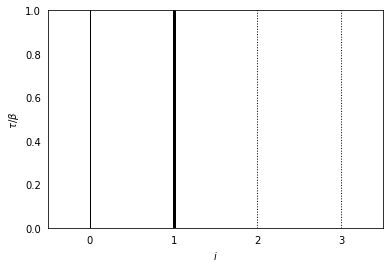

In [68]:
importlib.reload(pimc)
# Simulation parameters
t = 0
U = -1000
mu = -0.1
L = 4
N = 4
    
# PIMC parameters
beta = 1
eta = 1      # worm end fugacity
eta = 1/np.sqrt(L*beta)

# Canonical or Grand Canonical?
canonical = True

# Create a random worldline configuration
alpha = pimc.random_boson_config(L,N)
data_struct = pimc.create_data_struct(alpha)
head_loc = []
tail_loc = []
pimc.view_worldlines(data_struct,beta,figure_name=None)

### Do many iterations of the set of PIMC-WA updates

In [69]:
importlib.reload(pimc)
# Do insert many times on the above configuration
data_struct = pimc.create_data_struct(alpha)
head_loc = []
tail_loc = []
mc_steps = int(1E+06)
egs_list = []
n_list = []
occ_list = []
for m in range(mc_steps):
    
    pimc.worm_insert(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N) 
    pimc.worm_delete(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N)
    pimc.worm_timeshift(data_struct,beta,head_loc,tail_loc,U,mu,canonical,N)
    pimc.insert_gsworm_zero(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N)
    pimc.delete_gsworm_zero(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N)
    pimc.insert_gsworm_beta(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N)   
    pimc.delete_gsworm_beta(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N)

    # Calculate observables when there are no worms present
    if m >= 0.2*mc_steps and m%L==0: # Ignore unequilibrated data
        if head_loc == [] and tail_loc == []:
            egs_list.append(pimc.egs_pimc(data_struct,beta,U,mu)) # <E>
            n_list.append(pimc.n_pimc(data_struct,beta)/L) # <n>
            occ_list.append(pimc.n_i_pimc(data_struct,beta))
            
    # Measure <n>
    
    # Measure <n_i>

N_check:  4.000259745699317


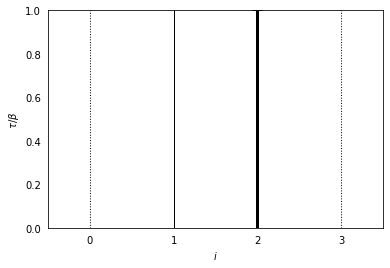

In [70]:
print("N_check: ",pimc.N_tracker(data_struct,beta))
pimc.view_worldlines(data_struct,beta,figure_name=None)

### Save data to file

In [71]:
egs_list = np.array(egs_list)
with open("egs_%i_%i_%.4f_%.4f_%.4f_%i.dat"%(L,N,U,mu,eta,mc_steps),"w+") as data:
    np.savetxt(data,egs_list,delimiter=",",fmt="%.16f",header="MC_step <E> // BH Parameters: L=%d,N=%d,U=%.8f,mu=%.8f,eta=%.8f,MC_steps=%i"%(L,N,U,mu,eta,mc_steps))
    
n_list = np.array(n_list)
with open("n_%i_%i_%.4f_%.4f_%.4f_%i.dat"%(L,N,U,mu,eta,mc_steps),"w+") as data:
    np.savetxt(data,n_list,delimiter=",",fmt="%.16f",header="MC_step <n> // BH Parameters: L=%d,N=%d,U=%.8f,mu=%.8f,eta=%.8f,MC_steps=%i"%(L,N,U,mu,eta,mc_steps))
    
n_i_list = np.array(n_i_list)
with open("occ_%i_%i_%.4f_%.4f_%.4f_%i.dat"%(L,N,U,mu,eta,mc_steps),"w+") as data:
    np.savetxt(data,n_i_list,delimiter=",",fmt="%.16f",header="MC_step <n_i> // BH Parameters: L=%d,N=%d,U=%.8f,mu=%.8f,eta=%.8f,MC_steps=%i"%(L,N,U,mu,eta,mc_steps))    
    
    
    
    

### Process data

In [72]:
egs = np.mean(egs_list)
n = np.mean(n_list)
occ = np.mean(occ_list,axis=0)
samples = len(egs_list)

In [73]:
occ

array([1.0402452 , 0.95948827, 0.94109808, 1.05916844])

In [74]:
importlib.reload(pimc)
print("Samples: %d"%samples)
print("-------- Ground State Energy --------")
print("PIMC: %.8f"%egs)
#print("Exact: %.8f"%pimc.egs_theory(L,U,mu))
print("-------- Average particles per site --------")
print("PIMC: %.8f"%n)
print("-------- Average occupation --------")
print("PIMC:",occ)

Samples: 3752
-------- Ground State Energy --------
PIMC: -4357.54243070
-------- Average particles per site --------
PIMC: 1.00000000
-------- Average occupation --------
PIMC: [1.0402452  0.95948827 0.94109808 1.05916844]


### Running average as a function of sample number

In [16]:
egs_mean = np.zeros(samples)
egs_total = 0
for i in range(samples):
    egs_total += egs_list[i]
    egs_mean[i] = egs_total/(i+1)

In [ ]:
sample_list = list(range(samples))
plt.plot(range(samples),egs_mean)
#plt.axhline()
plt.ylabel(r'$\langle E \rangle$')
plt.xlabel(r'$\mathrm{sample}$')
plt.savefig('egs_%i_%i_%.4f_%.4f_%.4f_%i.pdf'%(L,N,U,mu,eta,mc_steps))

### Test theoretical value

In [10]:
importlib.reload(pimc)
pimc.egs_theory(L,U,mu)

0.4

### Test the total particle number tracker

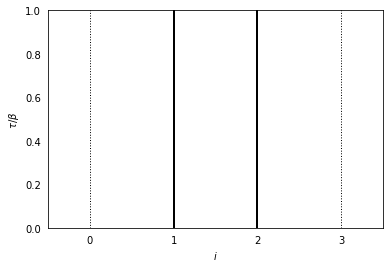

In [4]:
importlib.reload(pimc)
# Simulation parameters
N = 4
L = N   # unit-filling
t = 0
U = 1
n_min = 1
mu = U*(n_min-1/2)
mu = 0

canonical = True # False for Grand Canonical simulation
    
# PIMC parameters
beta = 1
eta = 1
#eta = 1/np.sqrt(L*beta)      # worm end fugacity

# Create unit filling initial configuration
alpha = []
for i in range(L):
    alpha.append(1)
alpha

alpha = [0,2,2,0]

data_struct = pimc.create_data_struct(alpha)
#data_struct[0].append([beta/2,0,(0,0)])
#data_struct[3].append([3*beta/4,0,(3,3)])

head_loc = []
tail_loc = []
pimc.view_worldlines(data_struct,beta,figure_name=None)

In [6]:
N_check = pimc.N_tracker(data_struct,beta)
egs = pimc.egs_pimc(data_struct,beta,U,mu)
N_check

4.0